In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
import math
import datetime
import adgeek_permission as permission
import facebook_datacollector as collector
import database_controller
sizepop, vardim, MAXGEN, params = 1000, 7, 15, [0.9, 0.5, 0.5]
BRANDING_CAMPAIGN_LIST = [
    'THRUPLAY', 'LINK_CLICKS', 'ALL_CLICKS','VIDEO_VIEWS', 'REACH', 'IMPRESSIONS', 'POST_ENGAGEMENT', 'PAGE_LIKES', 'LANDING_PAGE_VIEW']
PERFORMANCE_CAMPAIGN_LIST = [
    'CONVERSIONS', 'LEAD_GENERATION', 'ADD_TO_CART']

In [2]:
class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print ("Optimal solution is:")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()

class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        optimal_weight = OptimalWeight(self.chrom)
        self.fitness = np.dot(optimal_weight.matrix, chromosome.matrix)
#         self.fitness = ObjectiveFunc.fitnessfunc( self.chrom, df )


# def ga_optimal_weight(campaign_id):
#     request_time = datetime.datetime.now().date()
#     mydb = mysql_saver.connectDB( mysql_saver.DATABASE )
#     df_weight = pd.read_sql("SELECT * FROM optimal_weight WHERE campaign_id=%s " %(campaign_id), con=mydb)
#     df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s " %(campaign_id), con=mydb)
#     charge_type = df_camp['charge_type'].iloc[0]
#     adset_list = collector.Campaigns(campaign_id, charge_type).get_adsets_active()
#     if len(df_weight) > 0:
#         for adset_id in adset_list:
#             df = ObjectiveFunc.adset_status( adset_id, df_camp )
#             r = ObjectiveFunc.adset_fitness( df_weight, df )
#             print('[score]', r)
#             df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r, 'request_time':request_time}, index=[0])
#             try:
#                 mysql_saver.intoDB("adset_score", df_final)
#             except Exception as e:
#                 print('score is inf: ', e)
#                 pass
#     else:
#         pass
#     mydb.close()
#     return


In [3]:
def generate_optimal_weight(campaign_id, charge_type):
    global chromosome
    print('[campaign_id]:', campaign_id )
    print('[current time]: ', datetime.datetime.now() )
    start_time = datetime.datetime.now()
    
    campaign = Campaign(campaign_id)
    chromosome = ObjectChromosome(campaign.condition)

    bound = np.tile([[0], [1]], vardim)
    ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
    result_optimal_weight = ga.solve()
    
    optimal_campaign = CampaignOptimalWeight(campaign_id, charge_type, result_optimal_weight)
    
    score = np.dot(optimal_campaign.matrix, chromosome.matrix)
    print('==========SCORE========')
    print(score)

    score_columns=['w_action', 'w_desire', 'w_interest', 'w_awareness', 'w_discovery', 'w_spend', 'w_bid']
    df_score = pd.DataFrame(data=[optimal_campaign.matrix], columns=score_columns, index=[0])
    df_score['campaign_id'], df_score['score'] = campaign_id, score

    database_fb.upsert("campaign_optimal_weight", df_score.to_dict('records')[0])

    assess_adset(campaign, optimal_campaign)

    print('[optimal_weight]:', optimal_campaign.matrix)
    print('[operation time]: ', datetime.datetime.now()-start_time)

In [4]:
def assess_adset(campaign_object, campaign_optimal_object):
    for adset in campaign_object.adsets:
        
        chromosome_adset = ObjectChromosome(adset.condition)
        
        score = np.dot(campaign_optimal_object.matrix, chromosome_adset.matrix)
        
        print('=====[adset_id]=====', adset.adset_id, '==========[score]', score)

        database_fb.insert(
            "adset_score", 
            {'campaign_id':campaign_object.campaign_id, 'adset_id':adset.adset_id, 'score':score.item()}
        )


In [6]:
def main():
    starttime = datetime.datetime.now()
    print('[start time]: ', starttime)
    global database_fb
    db = database_controller.Database()
    database_fb = database_controller.FB(db)
    campaign_list = database_fb.get_branding_campaign().to_dict('records')
    print([campaign['campaign_id'] for campaign in campaign_list])
    for campaign in campaign_list:
        campaign_id = campaign.get("campaign_id")
        charge_type = campaign.get("charge_type")
        generate_optimal_weight(campaign_id, charge_type)
    
    campaign_list = database_fb.get_performance_campaign().to_dict('records')
    for campaign in campaign_list:
        campaign_id = campaign.get("campaign_id")
        charge_type = campaign.get("charge_type")
        generate_optimal_weight(campaign_id, charge_type)
        
    print('[total operation time]: ', datetime.datetime.now()-starttime)
    print('genetic algorithm finish.')
    return

In [7]:
class Campaign(object):
    __condition_field = ["action", "desire", "interest", "awareness", "attention", "discovery", "impressions", "destination_daily_spend",
                       "destination_daily_target", "cost_per_action", "spend", "daily_spend", "daily_target", "KPI", "destination_type"]
    def __init__(self, campaign_id):
        self.campaign_id = campaign_id
        self.__get_brief()
        self.brief_dict["destination_type"] = self.brief_dict.pop("charge_type")
        self.destination_type = self.brief_dict.get("destination_type")
        permission.init_facebook_api(self.brief_dict.get("account_id"))
        self.service_collect = collector.Campaigns(self.campaign_id, charge_type=None)
        self.__create_condition()
        self.__get_adsets()
        
    def __get_brief(self):
        df_list = database_fb.get_one_campaign(self.campaign_id).to_dict('records')

        self.brief_dict = df_list[0]
        self.brief_dict['KPI'] = self.brief_dict.get("ai_spend_cap")/self.brief_dict.get("destination")
    
    def get_weight(self):
        optimal_weight_list = database_fb.retrieve("optimal_weight", self.campaign_id).to_dict('records')
        
        return optimal_weight_list[0]
        
    def __get_adsets(self):
        adset_id_list = self.service_collect.get_adsets_active()
        self.adsets = [ AdSet(self, adset_id) for adset_id in adset_id_list ]
        
    def __create_condition(self):
        self.condition = self.service_collect.generate_info(date_preset = collector.DatePreset.lifetime)
        self.condition.update(self.brief_dict)
        self.condition.update({
            "flight": (datetime.date.today()-self.brief_dict.get("ai_start_date")).days
        })
        self.condition['spend'] = int(self.condition.get("spend") if self.condition.get("spend") else 0)
        self.condition['impressions'] = int(self.condition.get("impressions") if self.condition.get("impressions") else 0)
        self.condition.update({
            "attention": self.condition.get("impressions"),
            "discovery": self.condition.get("reach"),
            "destination_daily_spend": self.condition.get("ai_spend_cap") / self.condition.get("period"),
            "destination_daily_target":self.condition.get("destination") / self.condition.get("period"),
            "cost_per_action": self.condition.get("cost_per_target") if self.condition.get("cost_per_target") else 0,
            "spend": self.condition.get("spend") / self.condition.get("flight") if self.condition.get("flight") != 0 else 1,
            "action": self.condition.get("target") / self.condition.get("flight") if self.condition.get("flight") != 0 else 1,
        })
        self.condition = {k: v for k, v in self.condition.items() if k in self.__condition_field}
        
        
class AdSet(object):
    __condition_field = ["action", "desire", "interest", "awareness", "impressions", "destination_daily_spend",
                         "destination_daily_target", "bid_amount", "cost_per_action", "spend", "KPI", "destination_type"]
    def __init__(self, campaign, adset_id):
        self.campaign = campaign
        self.adset_id = adset_id
        self.destination_type = self.campaign.destination_type
        self.service_collect = collector.AdSets(self.adset_id, charge_type=None)
        self.__create_condition()
        
    def __create_condition(self):
        self.condition = self.service_collect.generate_info(date_preset = collector.DatePreset.lifetime)
        self.condition['spend'] = float(self.condition.get("spend") if self.condition.get("spend") else 0)
        self.condition['impressions'] = int(self.condition.get("impressions") if self.condition.get("impressions") else 0)
        self.condition.update({
            "KPI": self.campaign.condition.get("KPI"),
            "destination_type": self.destination_type,
            "destination_daily_spend": self.campaign.condition.get("destination_daily_spend"),
            "destination_daily_target": self.campaign.condition.get("destination_daily_target"),
            "cost_per_action": int(self.condition.get("spend")) / int(self.condition.get("action")) if int(self.condition.get("action")) != 0 else 0
        })
        self.condition = {k: v for k, v in self.condition.items() if k in self.__condition_field}
        
    def __create_fitness(self):
        self.fitness = Chromosome(self.condition)
        
    def __create_optimal_weight(self):
        self.optimal_weight = OptimalWeight(self.destination_type)



In [8]:
class OptimalWeight(object):        
    def __init__(self, optimal_weight):
        self.matrix = optimal_weight
        self.action = self.matrix[0]
        self.desire = self.matrix[1]
        self.interest = self.matrix[2]
        self.awareness = self.matrix[3]
        self.discovery = self.matrix[4]
        self.spend = self.matrix[5]
        self.kpi = self.matrix[6]

class CampaignOptimalWeight(OptimalWeight):
    def __init__(self, campaign_id, destination_type, optimal_weight):
        super().__init__(optimal_weight)
        self.destination_type = destination_type
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.desire, self.interest, self.awareness, self.discovery = 0, 0, 0, 0
            self.matrix = np.array([
                self.action, self.desire, self.interest, self.awareness, self.discovery, self.spend, self.kpi
            ])

    

In [9]:
class Chromosome(object):
    def __init__(self,):
        self.matrix = np.random.rand(vardim,)
        self.action = self.matrix[0]
        self.desire = self.matrix[1]
        self.interest = self.matrix[2]
        self.awareness = self.matrix[3]
        self.discovery = self.matrix[4]
        self.spend = self.matrix[5]
        self.kpi = self.matrix[6]

class RandomChromosome(Chromosome):
    pass

class ObjectChromosome(Chromosome):
    __fields = [
        "action", "desire", "interest", "awareness", "discovery", "attention", "spend"
    ]
    def __init__(self, condition):
        super().__init__()
        self.condition = condition
        self.destination_type = condition.get("destination_type")
        self.__initialize()
        self.__create_m_action()
        self.__create_m_desire()
        self.__create_m_interest()
        self.__create_m_awareness()
        self.__create_m_discovery()
        self.__create_m_spend()
        self.__create_m_kpi()
        self.__create_matrix()
        
    def __initialize(self):
        for field in self.__fields:
            if not self.condition.get(field):
                self.condition[field] = 0
        
    def __create_m_action(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_action = (self.condition.get("destination_daily_target")/int(self.condition.get("action"))) if int(self.condition.get("action")) != 0 else 0
        else:
            self.m_action = (int(self.condition.get("action")) / self.condition.get("desire")) if int(self.condition.get("desire")) != 0 else 0
        
    def __create_m_desire(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_desire = 0
        else:
            self.m_desire = (self.condition.get("desire") / self.condition.get("interest")) if self.condition.get("interest") != 0 else 0
        
    def __create_m_interest(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_interest = 0
        else:
            self.m_interest = (self.condition.get("interest") / self.condition.get("awareness")) if self.condition.get("awareness") != 0 else 0
        
    def __create_m_awareness(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_awareness = 0
        else:
            self.m_awareness = (self.condition.get("awareness") / self.condition.get("discovery")) if self.condition.get("discovery") != 0 else 0
        
    def __create_m_discovery(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_discovery = 0
        else:
            self.m_discovery = (self.condition.get("discovery") / self.condition.get("attention")) if self.condition.get("attention") != 0 else 0
        
    def __create_m_spend(self):
        self.m_spend = ( self.condition.get("destination_daily_spend")-self.condition.get("spend")) / self.condition.get("destination_daily_spend")
        
    def __create_m_kpi(self):
        self.m_kpi = ( self.condition.get("KPI")-self.condition.get("cost_per_action") ) / self.condition.get("KPI")
    
    def __create_matrix(self):
        self.matrix = np.array([
            self.m_action, self.m_desire, self.m_interest, self.m_awareness, self.m_discovery, self.m_spend, self.m_kpi
        ])
    


[start time]:  2019-08-23 16:39:21.015945
[23843447337770036, 23843508739720127, 23843628364880022, 23843672578810681]
[campaign_id]: 23843447337770036
[current time]:  2019-08-23 16:39:21.065935
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-06-19T16:56:48+0800


[get_adsets_active] adset_active_list: ['23843578121660036', '23843531828830036', '23843516369410036', '23843447338000036', '23843447337980036', '23843447337970036', '23843447337960036']


Generation 0: optimal function value is: 0.009781; average function value is 1.040422
Generation 1: optimal function value is: 0.990314; average function value is 0.634143
Generation 2: optimal function value is: 0.990314; average function value is 0.682779
Generation 3: optimal function value is: 0.990314; average function value is 0.704615
Generation 4: optimal function value is: 0.990314; average function value is 0.719704
Generation 5: optimal function value is: 0.990314; average function value is 0.733152
Generation 6: optimal function value is: 0.990314; average function value is 0.742449
Generation 7: optimal function value is: 0.990314; average function value is 0.750186
Generation 8: optimal function value is: 0.990314; average function value is 0.756481
Generation 9: optimal function value is: 0.990314; average function value is 0.760133
Generation 10: optimal function value is: 0.990314; average function value is 0.757380
Generation 11: optimal function value is: 0.990314; a

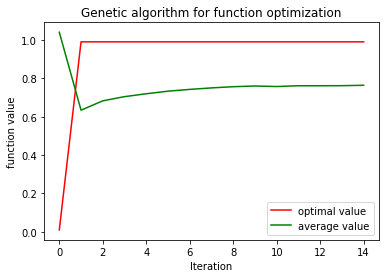

==========SCORE========
0.9903138568252602
=====[adset_id]===== 23843578121660036 ==========[score] 1.3926851749263864
=====[adset_id]===== 23843531828830036 ==========[score] 0.787103250245353
=====[adset_id]===== 23843516369410036 ==========[score] 0.06723037125770781
=====[adset_id]===== 23843447338000036 ==========[score] -1.7994529440958504
=====[adset_id]===== 23843447337980036 ==========[score] 0.08017610270481945
=====[adset_id]===== 23843447337970036 ==========[score] 1.4752172763888074
=====[adset_id]===== 23843447337960036 ==========[score] -3.300865500437367
[optimal_weight]: [0.90594572 0.         0.         0.         0.         0.54492973
 0.99977739]
[operation time]:  0:00:23.810179
[campaign_id]: 23843508739720127
[current time]:  2019-08-23 16:39:44.877543


[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-06-18T10:50:25+0800


[get_adsets_active] adset_active_list: ['23843699666220127', '23843651668300127', '23843629487990127']


Generation 0: optimal function value is: -0.167332; average function value is 0.767992
Generation 1: optimal function value is: 1.200959; average function value is 0.761011
Generation 2: optimal function value is: 1.200959; average function value is 0.833656
Generation 3: optimal function value is: 1.200959; average function value is 0.901009
Generation 4: optimal function value is: 1.200959; average function value is 0.939796
Generation 5: optimal function value is: 1.200959; average function value is 0.965387
Generation 6: optimal function value is: 1.202088; average function value is 0.991946
Generation 7: optimal function value is: 1.202088; average function value is 1.000892
Generation 8: optimal function value is: 1.202088; average function value is 1.021773
Generation 9: optimal function value is: 1.202088; average function value is 1.030489
Generation 10: optimal function value is: 1.202088; average function value is 1.043455
Generation 11: optimal function value is: 1.202088; 

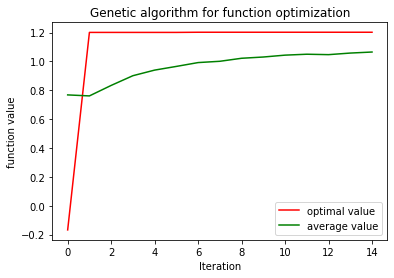

==========SCORE========
1.2020876522649924
=====[adset_id]===== 23843699666220127 ==========[score] 17.086023498437758
=====[adset_id]===== 23843651668300127 ==========[score] -1.0460662754936962
=====[adset_id]===== 23843629487990127 ==========[score] -0.33392141420398425
[optimal_weight]: [0.99841445 0.         0.         0.         0.         0.46179343
 0.0098184 ]
[operation time]:  0:00:20.770802
[campaign_id]: 23843628364880022
[current time]:  2019-08-23 16:40:05.649528
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-08-19T15:20:37+0800


[get_adsets_active] adset_active_list: ['23843628561170022', '23843628364970022', '23843628364960022', '23843628364940022', '23843628364930022', '23843628364920022', '23843628364870022']


Generation 0: optimal function value is: -0.199248; average function value is 0.510193
Generation 1: optimal function value is: 1.259301; average function value is 0.742948
Generation 2: optimal function value is: 1.259301; average function value is 0.796385
Generation 3: optimal function value is: 1.259301; average function value is 0.817973
Generation 4: optimal function value is: 1.259301; average function value is 0.834262
Generation 5: optimal function value is: 1.259301; average function value is 0.842947
Generation 6: optimal function value is: 1.259301; average function value is 0.852585
Generation 7: optimal function value is: 1.259301; average function value is 0.859899
Generation 8: optimal function value is: 1.259301; average function value is 0.865095
Generation 9: optimal function value is: 1.259301; average function value is 0.870439
Generation 10: optimal function value is: 1.259301; average function value is 0.875147
Generation 11: optimal function value is: 1.259301; 

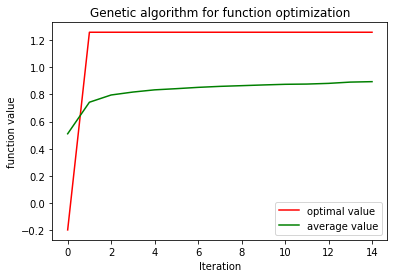

==========SCORE========
1.2593010151307453
=====[adset_id]===== 23843628561170022 ==========[score] 1.722793820377932
=====[adset_id]===== 23843628364970022 ==========[score] 1.834272566260731
=====[adset_id]===== 23843628364960022 ==========[score] 1.795870468593984
=====[adset_id]===== 23843628364940022 ==========[score] 1.8882137516143087
=====[adset_id]===== 23843628364930022 ==========[score] 1.8837996268302408
=====[adset_id]===== 23843628364920022 ==========[score] 1.3452806311869787
=====[adset_id]===== 23843628364870022 ==========[score] 1.6656852947231564
[optimal_weight]: [0.98977662 0.         0.         0.         0.         0.85999773
 0.99306857]
[operation time]:  0:00:23.651756
[campaign_id]: 23843672578810681
[current time]:  2019-08-23 16:40:29.302215
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3I

[get_adsets_active] adset_active_list: ['23843672578870681', '23843672578860681', '23843672578850681', '23843672578840681', '23843672578830681', '23843672578820681', '23843672578800681']


Generation 0: optimal function value is: 0.012293; average function value is 1.000887
Generation 1: optimal function value is: 0.990426; average function value is 0.615487
Generation 2: optimal function value is: 0.990426; average function value is 0.673798
Generation 3: optimal function value is: 0.990426; average function value is 0.687253
Generation 4: optimal function value is: 0.990426; average function value is 0.700550
Generation 5: optimal function value is: 0.990426; average function value is 0.717100
Generation 6: optimal function value is: 0.990426; average function value is 0.716896
Generation 7: optimal function value is: 0.990426; average function value is 0.732997
Generation 8: optimal function value is: 0.990426; average function value is 0.742117
Generation 9: optimal function value is: 0.990426; average function value is 0.749212
Generation 10: optimal function value is: 0.990426; average function value is 0.754630
Generation 11: optimal function value is: 0.990426; a

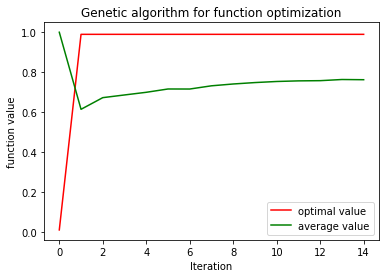

==========SCORE========
0.9904264010224036
=====[adset_id]===== 23843672578870681 ==========[score] 0.7477103319620326
=====[adset_id]===== 23843672578860681 ==========[score] 0.35988128821355786
=====[adset_id]===== 23843672578850681 ==========[score] -0.4305584975050033
=====[adset_id]===== 23843672578840681 ==========[score] 130.30806026697903
=====[adset_id]===== 23843672578830681 ==========[score] -7.431123262918355
=====[adset_id]===== 23843672578820681 ==========[score] 260.56765149354817
=====[adset_id]===== 23843672578800681 ==========[score] 72.00055325977763
[optimal_weight]: [0.97074342 0.         0.         0.         0.         0.29858935
 0.98930207]
[operation time]:  0:00:23.563020
[campaign_id]: 23842880697850266
[current time]:  2019-08-23 16:40:52.878196
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gL

[get_adsets_active] adset_active_list: ['23843717391720266', '23843717206480266', '23843717205420266', '23843708355320266', '23843707875590266']


Generation 0: optimal function value is: -0.941792; average function value is -0.887321
Generation 1: optimal function value is: 17.230743; average function value is 10.914585
Generation 2: optimal function value is: 17.230743; average function value is 12.305352
Generation 3: optimal function value is: 17.230743; average function value is 13.019518
Generation 4: optimal function value is: 17.230743; average function value is 13.376701
Generation 5: optimal function value is: 17.230743; average function value is 13.961240
Generation 6: optimal function value is: 17.230743; average function value is 14.198100
Generation 7: optimal function value is: 17.230743; average function value is 14.386699
Generation 8: optimal function value is: 17.230743; average function value is 14.483881
Generation 9: optimal function value is: 17.230743; average function value is 14.617639
Generation 10: optimal function value is: 17.230743; average function value is 14.669770
Generation 11: optimal function

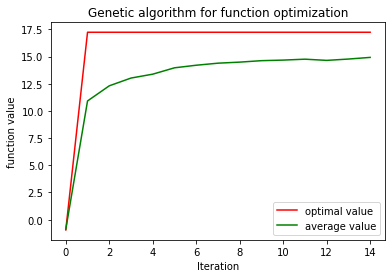

==========SCORE========
17.2307432114058
=====[adset_id]===== 23843717391720266 ==========[score] 1.6877397878345564
=====[adset_id]===== 23843717206480266 ==========[score] 1.6877397878345564
=====[adset_id]===== 23843717205420266 ==========[score] 27.75464426570901
=====[adset_id]===== 23843708355320266 ==========[score] 36.981065488588975
=====[adset_id]===== 23843707875590266 ==========[score] 55.60165195249656
[optimal_weight]: [0.61582423 0.28799294 0.98748612 0.23604164 0.74900075 0.77856595
 0.90917383]
[operation time]:  0:00:22.724268
[campaign_id]: 23843318062740647
[current time]:  2019-08-23 16:41:15.603382
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'cr

[get_adsets_active] adset_active_list: ['23843577190080647', '23843575282750647', '23843569214210647']


Generation 0: optimal function value is: -0.448267; average function value is 12.284103
Generation 1: optimal function value is: 1.852132; average function value is 0.964181
Generation 2: optimal function value is: 1.856880; average function value is 1.080661
Generation 3: optimal function value is: 1.856880; average function value is 1.159237
Generation 4: optimal function value is: 1.856880; average function value is 1.183233
Generation 5: optimal function value is: 1.856880; average function value is 1.231285
Generation 6: optimal function value is: 1.856880; average function value is 1.264227
Generation 7: optimal function value is: 1.856880; average function value is 1.281144
Generation 8: optimal function value is: 1.856880; average function value is 1.290591
Generation 9: optimal function value is: 1.856880; average function value is 1.293582
Generation 10: optimal function value is: 1.856880; average function value is 1.311262
Generation 11: optimal function value is: 1.856880;

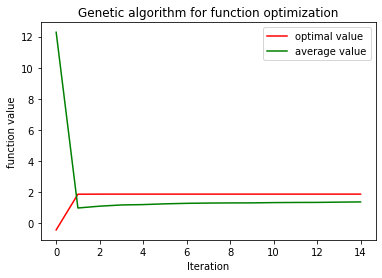

==========SCORE========
1.8568796198027888
=====[adset_id]===== 23843577190080647 ==========[score] 1.5106664803686465
=====[adset_id]===== 23843575282750647 ==========[score] 0.8827881145294358
=====[adset_id]===== 23843569214210647 ==========[score] 1.6262162389943609
[optimal_weight]: [0.87589218 0.84994792 0.99783308 0.29186369 0.87888735 0.81755015
 0.11020329]
[operation time]:  0:00:21.184968
[campaign_id]: 23843384204790368
[current time]:  2019-08-23 16:41:36.789594
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-04-08T08:30:28+0800


[get_adsets_active] adset_active_list: ['23843694481330368', '23843661314820368', '23843482074960368', '23843451198530368', '23843384205000368']


Generation 0: optimal function value is: 0.181811; average function value is 1.410708
Generation 1: optimal function value is: 0.846159; average function value is 0.497818
Generation 2: optimal function value is: 0.846159; average function value is 0.535380
Generation 3: optimal function value is: 0.846159; average function value is 0.558502
Generation 4: optimal function value is: 0.846159; average function value is 0.573361
Generation 5: optimal function value is: 0.846159; average function value is 0.584385
Generation 6: optimal function value is: 0.846159; average function value is 0.589814
Generation 7: optimal function value is: 0.846159; average function value is 0.595838
Generation 8: optimal function value is: 0.846159; average function value is 0.598760
Generation 9: optimal function value is: 0.846159; average function value is 0.602789
Generation 10: optimal function value is: 0.846159; average function value is 0.606042
Generation 11: optimal function value is: 0.846159; a

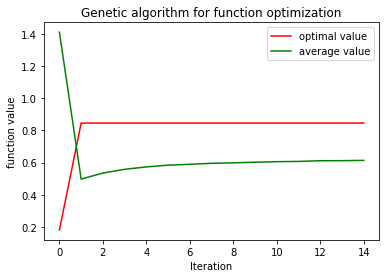

==========SCORE========
0.8461593000248003
=====[adset_id]===== 23843694481330368 ==========[score] 0.8629033448213519
=====[adset_id]===== 23843661314820368 ==========[score] 0.4023336955734892
=====[adset_id]===== 23843482074960368 ==========[score] -0.759071632734128
=====[adset_id]===== 23843451198530368 ==========[score] 0.007748517789552434
=====[adset_id]===== 23843384205000368 ==========[score] 0.0689015961728292
[optimal_weight]: [0.82891798 0.72558473 0.60002271 0.67355059 0.98169357 0.06843658
 0.96456868]
[operation time]:  0:00:22.600959
[campaign_id]: 23843473390820344
[current time]:  2019-08-23 16:41:59.391511
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': Non

[get_adsets_active] adset_active_list: ['23843511657650344', '23843511656660344', '23843477945310344', '23843476995720344', '23843473402760344']


Generation 0: optimal function value is: -0.582253; average function value is -0.224314
Generation 1: optimal function value is: 2.393792; average function value is 1.417394
Generation 2: optimal function value is: 2.393792; average function value is 1.507154
Generation 3: optimal function value is: 2.393792; average function value is 1.585101
Generation 4: optimal function value is: 2.393792; average function value is 1.599649
Generation 5: optimal function value is: 2.393792; average function value is 1.620145
Generation 6: optimal function value is: 2.393792; average function value is 1.625986
Generation 7: optimal function value is: 2.393792; average function value is 1.638320
Generation 8: optimal function value is: 2.393792; average function value is 1.640448
Generation 9: optimal function value is: 2.393792; average function value is 1.648889
Generation 10: optimal function value is: 2.393792; average function value is 1.651343
Generation 11: optimal function value is: 2.393792;

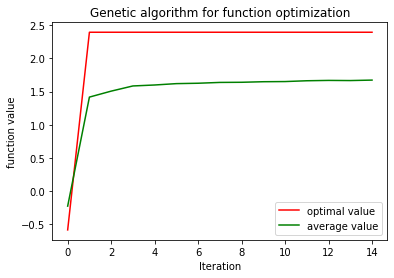

==========SCORE========
2.3937918264626052
=====[adset_id]===== 23843511657650344 ==========[score] 1.9519506277541057
=====[adset_id]===== 23843511656660344 ==========[score] 1.7208376965506518
=====[adset_id]===== 23843477945310344 ==========[score] 16.57570915703064
=====[adset_id]===== 23843476995720344 ==========[score] 5.837297302521503
=====[adset_id]===== 23843473402760344 ==========[score] 11.08613622680463
[optimal_weight]: [0.77868096 0.18978283 0.44844691 0.80554283 0.85739634 0.96451263
 0.987438  ]
[operation time]:  0:00:23.315250
[campaign_id]: 23843636617110232
[current time]:  2019-08-23 16:42:22.708083
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'c

[get_adsets_active] adset_active_list: ['23843636617280232', '23843636617270232']


Generation 0: optimal function value is: -0.405789; average function value is 0.130520
Generation 1: optimal function value is: 1.682903; average function value is 0.980967
Generation 2: optimal function value is: 1.682903; average function value is 1.035639
Generation 3: optimal function value is: 1.690685; average function value is 1.056400
Generation 4: optimal function value is: 1.690685; average function value is 1.093670
Generation 5: optimal function value is: 1.690685; average function value is 1.105705
Generation 6: optimal function value is: 1.690685; average function value is 1.113556
Generation 7: optimal function value is: 1.690685; average function value is 1.123069
Generation 8: optimal function value is: 1.690685; average function value is 1.129581
Generation 9: optimal function value is: 1.690685; average function value is 1.131653
Generation 10: optimal function value is: 1.690685; average function value is 1.133419
Generation 11: optimal function value is: 1.690685; 

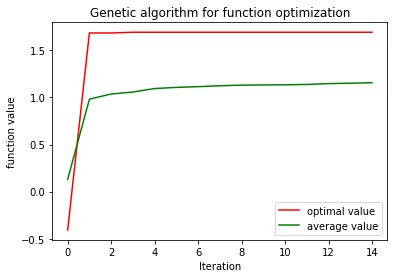

==========SCORE========
1.6906853783715214
=====[adset_id]===== 23843636617280232 ==========[score] 1.7285981288055834


=====[adset_id]===== 23843636617270232 ==========[score] -0.39677942038300484
[optimal_weight]: [0.02920105 0.64493037 0.66562212 0.08814144 0.98248751 0.94087552
 0.96319589]
[operation time]:  0:00:19.533921
[campaign_id]: 23843685426300680
[current time]:  2019-08-23 16:42:42.242803
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-08-16T14:31:01+0800


[get_adsets_active] adset_active_list: ['23843703703420680', '23843685426360680', '23843685426340680']


Generation 0: optimal function value is: -0.664849; average function value is -0.323779
Generation 1: optimal function value is: 2.983729; average function value is 1.736603
Generation 2: optimal function value is: 2.983729; average function value is 1.881840
Generation 3: optimal function value is: 2.983729; average function value is 1.942055
Generation 4: optimal function value is: 2.983729; average function value is 2.011469
Generation 5: optimal function value is: 2.983729; average function value is 2.049408
Generation 6: optimal function value is: 2.983729; average function value is 2.097244
Generation 7: optimal function value is: 2.983729; average function value is 2.106138
Generation 8: optimal function value is: 2.983729; average function value is 2.141448
Generation 9: optimal function value is: 2.983729; average function value is 2.164587
Generation 10: optimal function value is: 2.983729; average function value is 2.191994
Generation 11: optimal function value is: 2.983729;

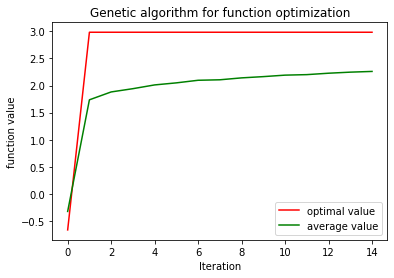

==========SCORE========
2.983728804806739
=====[adset_id]===== 23843703703420680 ==========[score] 1.0000935128069894
=====[adset_id]===== 23843685426360680 ==========[score] 2.684287361289509
=====[adset_id]===== 23843685426340680 ==========[score] 0.7575633846791945
[optimal_weight]: [0.3790437  0.92750129 0.99848733 0.87782576 0.70607532 0.95997061
 0.0401229 ]
[operation time]:  0:00:20.263342
[campaign_id]: 23843098840440451
[current time]:  2019-08-23 16:43:02.518325
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2018-11-15T09:25:08+0800


[get_adsets_active] adset_active_list: ['23843661845390451', '23843661659950451', '23843660496330451', '23843621652590451', '23843345040900451']


Generation 0: optimal function value is: -0.544233; average function value is -0.227651
Generation 1: optimal function value is: 2.262782; average function value is 1.385096
Generation 2: optimal function value is: 2.262782; average function value is 1.493523
Generation 3: optimal function value is: 2.262782; average function value is 1.554533
Generation 4: optimal function value is: 2.262782; average function value is 1.569975
Generation 5: optimal function value is: 2.262782; average function value is 1.601557
Generation 6: optimal function value is: 2.262782; average function value is 1.630615
Generation 7: optimal function value is: 2.262782; average function value is 1.652656
Generation 8: optimal function value is: 2.262782; average function value is 1.675566
Generation 9: optimal function value is: 2.262782; average function value is 1.693192
Generation 10: optimal function value is: 2.262782; average function value is 1.720463
Generation 11: optimal function value is: 2.262782;

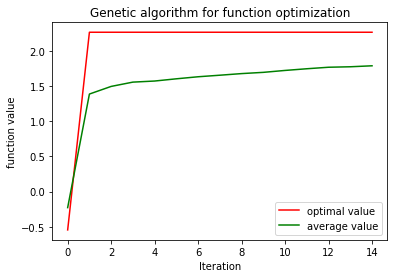

==========SCORE========
2.262781922191202
=====[adset_id]===== 23843661845390451 ==========[score] 1.5615581166415042
=====[adset_id]===== 23843661659950451 ==========[score] 4.215209182443057
=====[adset_id]===== 23843660496330451 ==========[score] 8.320574623775649
=====[adset_id]===== 23843621652590451 ==========[score] 2.2211005415642173
=====[adset_id]===== 23843345040900451 ==========[score] 2.813345417011109
[optimal_weight]: [0.68640487 0.92910515 0.84471984 0.37661786 0.94690481 0.94982275
 0.61173536]
[operation time]:  0:00:22.518815
[campaign_id]: 23843412155100631
[current time]:  2019-08-23 16:43:25.037944
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'cr

[get_adsets_active] adset_active_list: ['23843636299800631', '23843624756900631', '23843624756880631']


Generation 0: optimal function value is: -0.652122; average function value is -0.171774
Generation 1: optimal function value is: 2.874572; average function value is 1.549199
Generation 2: optimal function value is: 2.874572; average function value is 1.759683
Generation 3: optimal function value is: 2.874572; average function value is 1.845840
Generation 4: optimal function value is: 2.874572; average function value is 1.885938
Generation 5: optimal function value is: 2.874572; average function value is 1.958111
Generation 6: optimal function value is: 2.874572; average function value is 1.983094
Generation 7: optimal function value is: 2.874572; average function value is 2.015551
Generation 8: optimal function value is: 2.874572; average function value is 2.045053
Generation 9: optimal function value is: 2.874572; average function value is 2.084196
Generation 10: optimal function value is: 2.874572; average function value is 2.120294
Generation 11: optimal function value is: 2.874572;

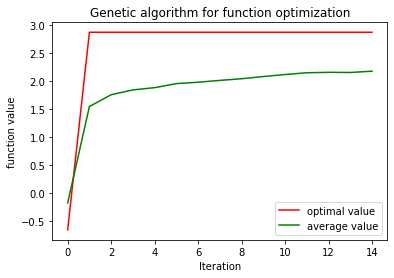

==========SCORE========
2.8745719346045457
=====[adset_id]===== 23843636299800631 ==========[score] 6.144942197911663
=====[adset_id]===== 23843624756900631 ==========[score] 0.9042944291364701
=====[adset_id]===== 23843624756880631 ==========[score] -0.8273514793548941
[optimal_weight]: [0.11224202 0.97217301 0.99885296 0.16353098 0.83828325 0.91529363
 0.06562217]
[operation time]:  0:00:21.020209
[campaign_id]: 23843468131980091
[current time]:  2019-08-23 16:43:46.058949
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-07-27T00:00:16+0800


[get_adsets_active] adset_active_list: ['23843528799410091', '23843527786530091', '23843521405370091', '23843521395560091', '23843508308220091', '23843468170280091']


Generation 0: optimal function value is: -0.686996; average function value is -0.384911
Generation 1: optimal function value is: 3.283636; average function value is 1.989692
Generation 2: optimal function value is: 3.283636; average function value is 2.153338
Generation 3: optimal function value is: 3.283636; average function value is 2.290154
Generation 4: optimal function value is: 3.283636; average function value is 2.376458
Generation 5: optimal function value is: 3.283636; average function value is 2.424279
Generation 6: optimal function value is: 3.283636; average function value is 2.473890
Generation 7: optimal function value is: 3.283636; average function value is 2.517080
Generation 8: optimal function value is: 3.283636; average function value is 2.537728
Generation 9: optimal function value is: 3.283636; average function value is 2.549535
Generation 10: optimal function value is: 3.283636; average function value is 2.584186
Generation 11: optimal function value is: 3.283636;

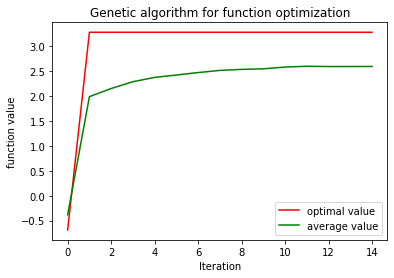

==========SCORE========
3.2836359931351384
=====[adset_id]===== 23843528799410091 ==========[score] 2.5670364204638094
=====[adset_id]===== 23843527786530091 ==========[score] 2.9967494866535715
=====[adset_id]===== 23843521405370091 ==========[score] 4.996964673059874
=====[adset_id]===== 23843521395560091 ==========[score] 1.5860209052377106
=====[adset_id]===== 23843508308220091 ==========[score] 2.0976229156148585
=====[adset_id]===== 23843468170280091 ==========[score] 0.0707358746499511
[optimal_weight]: [0.65150644 0.97224242 0.98917451 0.56693    0.86595337 0.28038823
 0.81951146]
[operation time]:  0:00:22.833912
[campaign_id]: 23843488842640474
[current time]:  2019-08-23 16:44:08.894270
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8M

[get_adsets_active] adset_active_list: ['23843522131070474', '23843522124710474']


Generation 0: optimal function value is: -0.685733; average function value is -0.116529
Generation 1: optimal function value is: 3.182007; average function value is 1.523039
Generation 2: optimal function value is: 3.182007; average function value is 1.686728
Generation 3: optimal function value is: 3.182007; average function value is 1.787087
Generation 4: optimal function value is: 3.182007; average function value is 1.850579
Generation 5: optimal function value is: 3.182007; average function value is 1.918259
Generation 6: optimal function value is: 3.182007; average function value is 1.950658
Generation 7: optimal function value is: 3.182007; average function value is 1.980890
Generation 8: optimal function value is: 3.182007; average function value is 2.036182
Generation 9: optimal function value is: 3.182007; average function value is 2.065914
Generation 10: optimal function value is: 3.182007; average function value is 2.078512
Generation 11: optimal function value is: 3.182007;

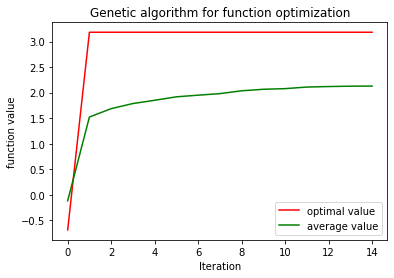

==========SCORE========
3.1820065961965596
=====[adset_id]===== 23843522131070474 ==========[score] 3.293076843228492
=====[adset_id]===== 23843522124710474 ==========[score] 2.7154860402056906
[optimal_weight]: [0.90681338 0.98905273 0.93386264 0.46889942 0.75901728 0.05128762
 0.94014273]
[operation time]:  0:00:19.575925
[campaign_id]: 23843536795940014
[current time]:  2019-08-23 16:44:28.471579
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-08-08T14:04:05+0800


[get_adsets_active] adset_active_list: ['23843585944280014', '23843574129480014', '23843574128500014', '23843547933390014', '23843536795980014']


Generation 0: optimal function value is: -0.617367; average function value is -1.768870
Generation 1: optimal function value is: 2.613472; average function value is -2.878536
Generation 2: optimal function value is: 2.613472; average function value is -3.107798
Generation 3: optimal function value is: 2.613472; average function value is -3.288180
Generation 4: optimal function value is: 2.613472; average function value is -3.321273
Generation 5: optimal function value is: 2.613472; average function value is -3.443963
Generation 6: optimal function value is: 2.613472; average function value is -3.471715
Generation 7: optimal function value is: 2.613472; average function value is -3.492407
Generation 8: optimal function value is: 2.613472; average function value is -3.530218
Generation 9: optimal function value is: 2.613472; average function value is -3.532867
Generation 10: optimal function value is: 2.613472; average function value is -3.548453
Generation 11: optimal function value is:

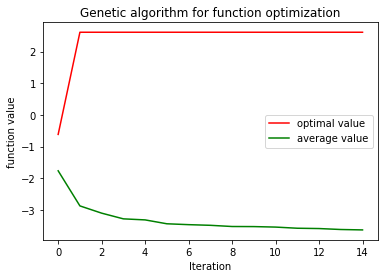

==========SCORE========
2.6134717817186024
=====[adset_id]===== 23843585944280014 ==========[score] 0.8573967761213382
=====[adset_id]===== 23843574129480014 ==========[score] 1.6346331342670155
=====[adset_id]===== 23843574128500014 ==========[score] 0.0005631258610873935
=====[adset_id]===== 23843547933390014 ==========[score] 0.8573967761213382
=====[adset_id]===== 23843536795980014 ==========[score] 1.3039872567930204
[optimal_weight]: [0.198405   0.89318096 0.81176224 0.68323294 0.88945421 0.83907564
 0.01832114]
[operation time]:  0:00:22.142175
[campaign_id]: 23843607936320431
[current time]:  2019-08-23 16:44:50.615355
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': No

[get_adsets_active] adset_active_list: ['23843710906030431', '23843710903950431', '23843657922110431', '23843657916530431', '23843607939050431', '23843607939030431']


Generation 0: optimal function value is: -0.553558; average function value is -0.164789
Generation 1: optimal function value is: 2.263325; average function value is 1.312992
Generation 2: optimal function value is: 2.263325; average function value is 1.422721
Generation 3: optimal function value is: 2.263325; average function value is 1.474449
Generation 4: optimal function value is: 2.268351; average function value is 1.525570
Generation 5: optimal function value is: 2.268351; average function value is 1.556197
Generation 6: optimal function value is: 2.268351; average function value is 1.590546
Generation 7: optimal function value is: 2.268351; average function value is 1.622316
Generation 8: optimal function value is: 2.268351; average function value is 1.646012
Generation 9: optimal function value is: 2.268351; average function value is 1.668577
Generation 10: optimal function value is: 2.268351; average function value is 1.672297
Generation 11: optimal function value is: 2.268351;

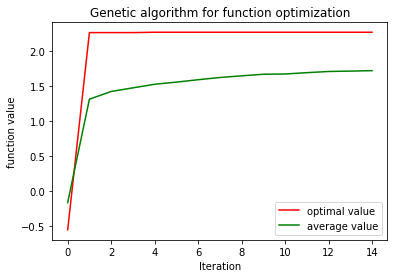

==========SCORE========
2.2683512992316754
=====[adset_id]===== 23843710906030431 ==========[score] 1.3063921470221906
=====[adset_id]===== 23843710903950431 ==========[score] 1.3063921470221906
=====[adset_id]===== 23843657922110431 ==========[score] 2.957903436243587
=====[adset_id]===== 23843657916530431 ==========[score] 2.9633668452631374
=====[adset_id]===== 23843607939050431 ==========[score] 4.380101703040837
=====[adset_id]===== 23843607939030431 ==========[score] 2.001233686402538
[optimal_weight]: [0.73463656 0.94048073 0.92320175 0.38860472 0.9555369  0.55704239
 0.74934976]
[operation time]:  0:00:23.048753
[campaign_id]: 23843646477870386
[current time]:  2019-08-23 16:45:13.665595
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McA

[get_adsets_active] adset_active_list: ['23843646478030386', '23843646478010386']


Generation 0: optimal function value is: -0.733923; average function value is -0.502665
Generation 1: optimal function value is: 3.758305; average function value is 2.186806
Generation 2: optimal function value is: 3.758305; average function value is 2.333922
Generation 3: optimal function value is: 3.758305; average function value is 2.421241
Generation 4: optimal function value is: 3.758305; average function value is 2.526109
Generation 5: optimal function value is: 3.758305; average function value is 2.605193
Generation 6: optimal function value is: 3.758305; average function value is 2.646114
Generation 7: optimal function value is: 3.758305; average function value is 2.685811
Generation 8: optimal function value is: 3.758305; average function value is 2.726754
Generation 9: optimal function value is: 3.758305; average function value is 2.742738
Generation 10: optimal function value is: 3.758305; average function value is 2.747271
Generation 11: optimal function value is: 3.758305;

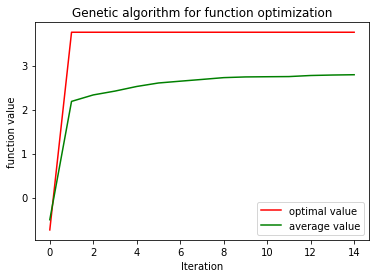

==========SCORE========
3.7583053664038024
=====[adset_id]===== 23843646478030386 ==========[score] -2.862262551931742
=====[adset_id]===== 23843646478010386 ==========[score] -1.2664068047623864
[optimal_weight]: [0.88172448 0.92701924 0.87900742 0.81889714 0.9575818  0.96657141
 0.96187221]
[operation time]:  0:00:19.829227
[total operation time]:  0:06:12.479848
genetic algorithm finish.


In [10]:
if __name__ == "__main__":
    main()
    import gc
    gc.collect()
#     main(campaign_id=23843467729120098)

In [12]:
# !jupyter nbconvert --to script genetic_algorithm.ipynb

[NbConvertApp] Converting notebook genetic_algorithm.ipynb to script
[NbConvertApp] Writing 20650 bytes to genetic_algorithm.py
